In [416]:
from core.rolling_analysis import RollingAnalyzer
from core.utils import get_dfs, get_good_dfs, \
get_close_prices, fix_gaps_in_data, calc_returns, \
calc_log_prices, get_pairs
from sklearn.preprocessing import FunctionTransformer

import warnings
import numpy
import pandas as pd



warnings.simplefilter(action='ignore', category=FutureWarning)
m = 1000

print("getting data")
dfs = get_dfs("data")
print("filtering to good ones")
good_dfs = get_good_dfs(dfs, 30000)
print("getting close prices")
closes = get_close_prices(good_dfs)
print("filling gaps")
closes = fix_gaps_in_data(closes)
print("filtering to USDT")
pairs = get_pairs(good_dfs)
closes_usdt = closes[pairs['USD']]

print("calculating log prices")
log_df = calc_log_prices(closes_usdt)
filtered_df = log_df

print("calculating returns")
returns = calc_returns(closes_usdt)
print("-------------------")
print("Now rolling analysis")
rolling_analyzer = RollingAnalyzer(filtered_df, m)
print("Make the dfs")
rolling_analyzer.make_dfs()
rolling_analyzer.asset_loop()
print("Running all the regressions")
# rolling_analyzer.run_all_regressions()
rolling_analyzer.run_all_regressions()
rolling_analyzer.calc_all_returns_stats()

# print("Calculating dickey fullers")
rolling_analyzer.calc_dickey_fuller('BTCUSDT', 'ETHUSDT')
# rolling_analyzer.calc_dickey_fuller('BTCUSDT', 'LTCUSDT')

getting data
filtering to good ones
getting close prices
filling gaps
filtering to USDT
calculating log prices
calculating returns
-------------------
Now rolling analysis
Make the dfs
Running all the regressions
('LTCUSDT', 'BNBUSDT')
('TRXUSDT', 'BNBUSDT')
('TRXUSDT', 'LTCUSDT')
('ETHUSDT', 'BNBUSDT')
('ETHUSDT', 'LTCUSDT')
('ETHUSDT', 'TRXUSDT')
('BTCUSDT', 'BNBUSDT')
('BTCUSDT', 'LTCUSDT')
('BTCUSDT', 'TRXUSDT')
('BTCUSDT', 'ETHUSDT')
('EOSUSDT', 'BNBUSDT')
('EOSUSDT', 'LTCUSDT')
('EOSUSDT', 'TRXUSDT')
('EOSUSDT', 'ETHUSDT')
('EOSUSDT', 'BTCUSDT')
('ADAUSDT', 'BNBUSDT')
('ADAUSDT', 'LTCUSDT')
('ADAUSDT', 'TRXUSDT')
('ADAUSDT', 'ETHUSDT')
('ADAUSDT', 'BTCUSDT')
('ADAUSDT', 'EOSUSDT')
('XRPUSDT', 'BNBUSDT')
('XRPUSDT', 'LTCUSDT')
('XRPUSDT', 'TRXUSDT')
('XRPUSDT', 'ETHUSDT')
('XRPUSDT', 'BTCUSDT')
('XRPUSDT', 'EOSUSDT')
('XRPUSDT', 'ADAUSDT')


In [437]:
import numpy as np
import matplotlib.pyplot as plt

mean_returns_df = rolling_analyzer.export_returns_stats_df(stat='mean_return')
volatility_df = rolling_analyzer.export_returns_stats_df(stat='volatility')
dickey_fuller_df = rolling_analyzer.export_dickey_fuller_df()
betas_df = rolling_analyzer.export_betas_df()

In [438]:
t = np.where(dickey_fuller_df > 0.9)[0][0]
dickey_fuller_df.iloc[t, :]

BTCUSDT_ETHUSDT    0.958102
Name: 2018-07-07 07:45:00+00:00, dtype: float64

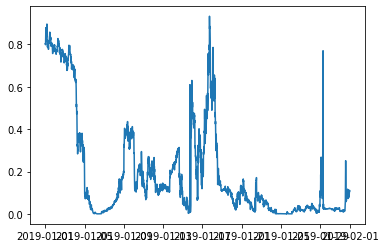

In [439]:
series = dickey_fuller_df['BTCUSDT_ETHUSDT']

plt.plot(series['2019-01-01':'2019-01-31'])

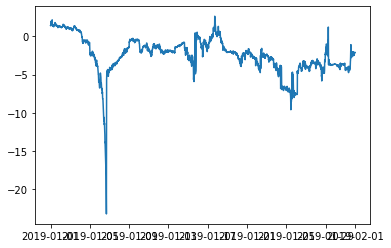

In [440]:
def zero_to_one(x):
    return np.exp(x)/(1+np.exp(x))

def to_infinity(x):
    np.log(x/(1-x))


inf_dickey_fuller = np.log(series/(1-series))
plt.plot(inf_dickey_fuller['2019-01-01':'2019-01-31'])

In [441]:
y = pd.DataFrame(inf_dickey_fuller.shift(-m))
y.columns = ['y']

full_df = pd.concat([mean_returns_df, volatility_df, betas_df, y], axis=1).dropna()
full_df = full_df.replace([np.inf, -np.inf], 0)

In [442]:
def make_train_test(df, ratio = 0.2, target='y'):
    split_point = int((1 - ratio) * df.shape[0])
    y = df[target]
    x = df.drop([target], axis=1)
    y_train = y[0:split_point]
    x_train = x[0:split_point]
    y_test = y[(split_point + 1):]
    x_test = x[(split_point + 1):]
    out = {'train': {'x': x_train, 'y': y_train},
           'test': {'x': x_test, 'y': y_test}
          }
    return out
    
full_set = make_train_test(full_df)

In [432]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


scaler = StandardScaler()

x_scaled = scaler.fit_transform(full_set['train']['x'])
y_scaled = scaler.fit_transform(pd.DataFrame(full_set['train']['y']))

model = SVR()
model.fit(x_scaled, y_scaled)

/Users/alex/ml_class/project_venv/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

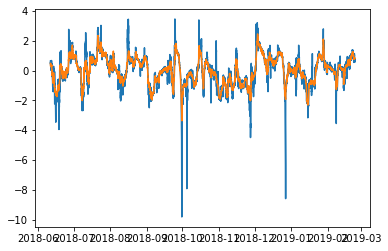

In [433]:
predicted = pd.Series(model.predict(x_scaled), index=full_set['train']['x'].index)
y_series = pd.DataFrame(y_scaled, index=full_set['train']['y'].index)
plt.plot(y_series)
plt.plot(predicted)

In [434]:
def time_series_kfolds(df, folds=3):
    subset_row_n = int(df.shape[0] / folds)
    out = []
    for i in range (0, folds):
        subset = df[i * subset_row_n:(i+1) * subset_row_n]
        out.append(subset)
    return out

k = 10
kfolds = time_series_kfolds(full_set['train']['y'], folds=k)


In [435]:
def time_series_cross_val_predict(model, x, y, folds=10):
    if folds < 5:
        print("Must have 5 or more folds")
        return
    else:
        x_folds = time_series_kfolds(x, folds=folds)
        y_folds = time_series_kfolds(y, folds=folds)
        predictions = []
        true_values = []
        for i in range(3, folds):
            x_train = pd.concat([x_folds[i-3], x_folds[i-2], x_folds[i-1]], axis=0)
            y_train = pd.concat([y_folds[i-3], y_folds[i-2], y_folds[i-1]], axis=0)
            x_test = x_folds[i]
            true_values.append(y_folds[i])
            model.fit(x_train, y_train)
            temp_predictions = model.predict(x_test)
            predictions.append(temp_predictions)
        out = {'true_values': true_values, 'predictions': predictions}
        return out

In [345]:
pipeline = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('svr', SVR(C=0.5, kernel='poly'))
])

cross_val_predictions = time_series_cross_val_predict(
    pipeline,
    full_set['train']['x'],
    full_set['train']['y'], folds=20
)

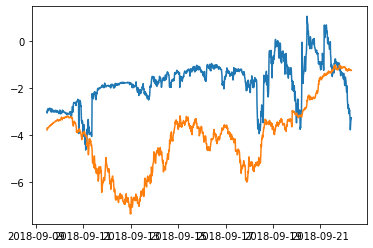

In [409]:
fold = 4

plt.plot(cross_val_predictions['true_values'][fold])
prediction_s = pd.Series(
    cross_val_predictions['predictions'][fold],
    index=cross_val_predictions['true_values'][fold].index
)
plt.plot(prediction_s)

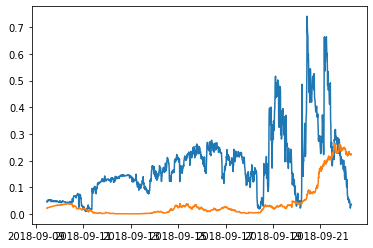

In [355]:
plt.plot(zero_to_one(cross_val_predictions['true_values'][fold]))
plt.plot(zero_to_one(prediction_s))

In [359]:
from sklearn.metrics import mean_squared_error

zero_to_one(np.sqrt(mean_squared_error(cross_val_predictions['true_values'][fold], prediction_s)))

0.9423785494083549

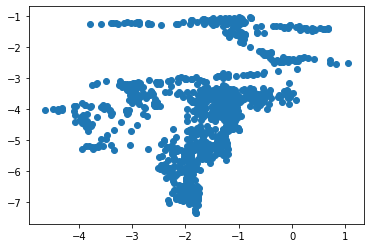